In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"
NUCDIR = "/storage/mgymrek/gtex-estrs/revision/homer-plots/composite/"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest
from sklearn.cluster import KMeans

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

prefcol = {
    "GM12878": "gray",
    "heart": "red",
    "aheart": "pink",
    "lung": "green",
    "tibial-artery": "maroon",
    "tibial-nerve": "gold",
    "fat": "brown",
    "esophagus": "orange",
    "skin": "cyan"
}
prefcols = ["fat","esophagus","skin", "GM12878","heart","lung","aheart","tibial-artery","tibial-nerve"]

# Load nucleosome data by period
nucdata = []
nucdata_all = []
dnasedata = []
dnasedata_all = []

dnasedata_by_tissue = {}
for t in TISSUES: dnasedata_by_tissue[t] = []

dnasecols = ["dist"]
for p in prefcols:
    dnasecols.extend(["cov.%s"%p,"+.%s"%p,"-.%s"%p])
    
for period in range(1, 7):
    d = pd.read_csv(os.path.join(NUCDIR, "ALLCAUSAL_nucl_period%s.bed"%period), sep="\t")
    d.columns = ["dist","cov","+","-"]
    nucdata.append(d)
    
    d = pd.read_csv(os.path.join(NUCDIR, "ALLSTRs_nucl_period%s.bed"%period), sep="\t")
    d.columns = ["dist","cov","+","-"]
    nucdata_all.append(d)
    
    d = pd.read_csv(os.path.join(NUCDIR, "ALLCAUSAL_dnase_period%s.bed"%period), sep="\t")
    d.columns = dnasecols
    dnasedata.append(d)
    
    d = pd.read_csv(os.path.join(NUCDIR, "ALLSTRs_dnase_period%s.bed"%period), sep="\t")
    d.columns = dnasecols
    dnasedata_all.append(d)
    
    for tissue in TISSUES:
        d = pd.read_csv(os.path.join(NUCDIR, "%s_dnase_period%s.bed"%(tissue, period)), sep="\t")
        d.columns = dnasecols
        dnasedata_by_tissue[tissue].append(d)

Populating the interactive namespace from numpy and matplotlib


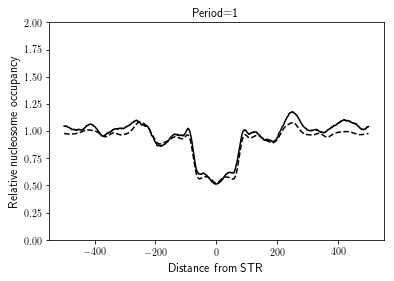

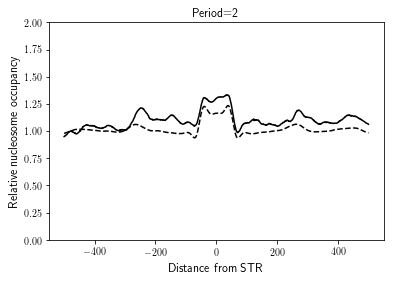

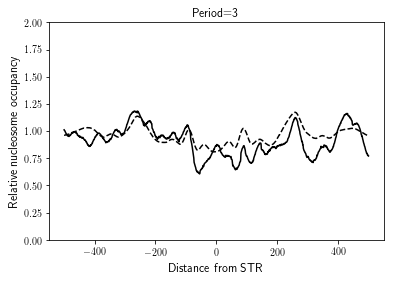

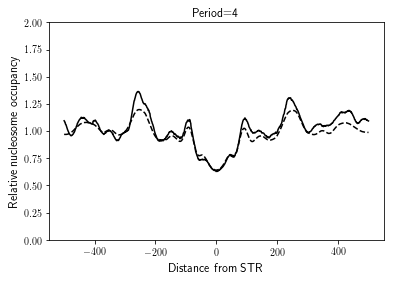

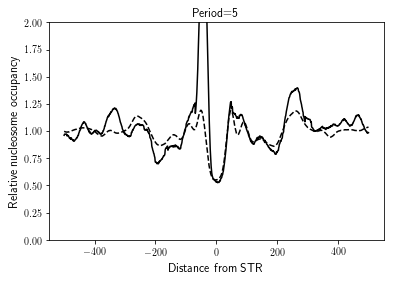

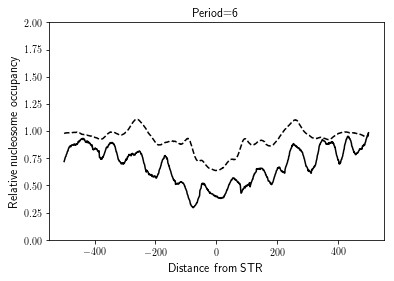

In [2]:
# Plot nucleosome density by period - causal vs. all STRs
for period in range(1, 7): 
    d = nucdata[period-1]
    dall = nucdata_all[period-1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(d["dist"],d["cov"], color="black")
    ax.plot(dall["dist"],dall["cov"], color="black", linestyle="dashed")
    ax.set_xlabel("Distance from STR", size=12)
    ax.set_ylim(bottom=0, top=2)
    ax.set_ylabel("Relative nucleosome occupancy", size=12)
    ax.set_title("Period=%s"%period);

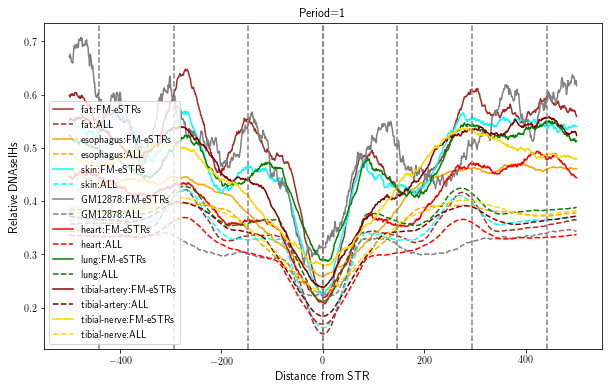

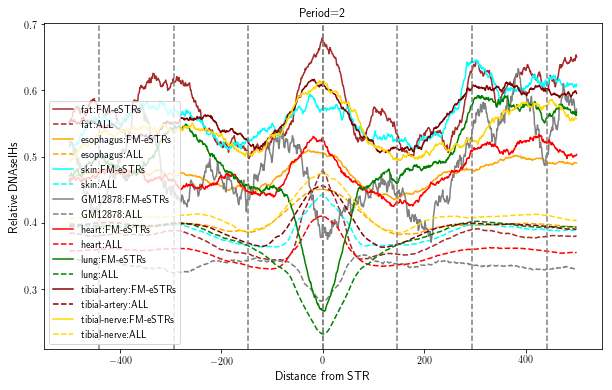

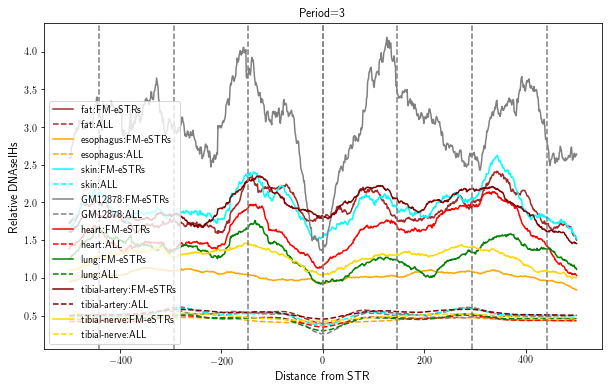

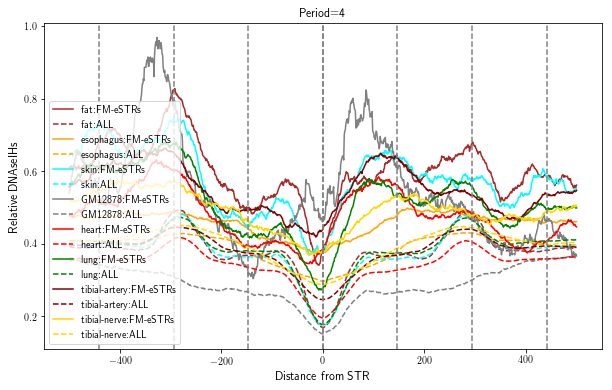

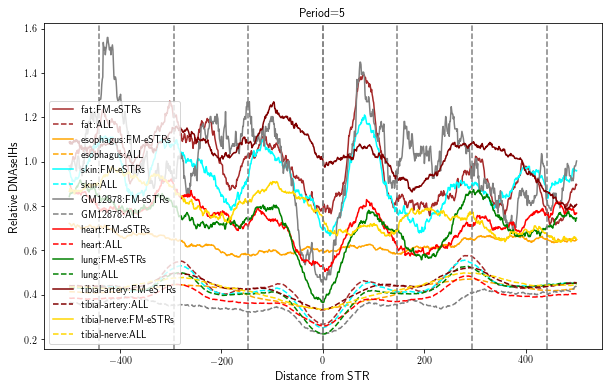

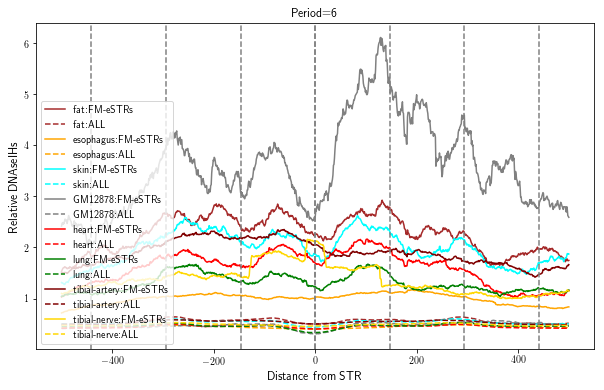

In [3]:
# Plot DNAseI by period - causal vs. all STRs, for each tissue type
for period in range(1, 7):
    d = dnasedata[period-1]
    dall = dnasedata_all[period-1]
    fig = plt.figure()
    fig.set_size_inches((10,6))
    ax = fig.add_subplot(111)
    for pref in prefcols:
        if pref == "aheart": continue # this one looks weird
        ax.plot(d["dist"],d["cov.%s"%pref], color=prefcol[pref], label=pref+":FM-eSTRs")
        ax.plot(dall["dist"],dall["cov.%s"%pref], color=prefcol[pref], linestyle="dashed", label=pref+":ALL")
    ax.set_xlabel("Distance from STR", size=12)
    ax.set_ylabel("Relative DNAseIHs", size=12)
    ax.set_title("Period=%s"%period)
    ax.legend(loc="lower left")
    
    for mult in range(4):
        ax.axvline(x=mult*147, linestyle="dashed", color="gray")
        ax.axvline(x=-1*mult*147, linestyle="dashed", color="gray")

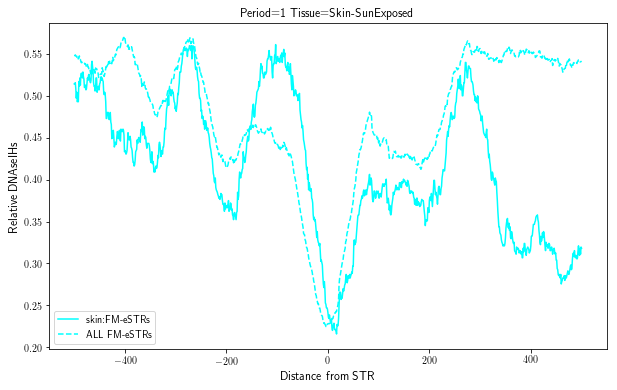

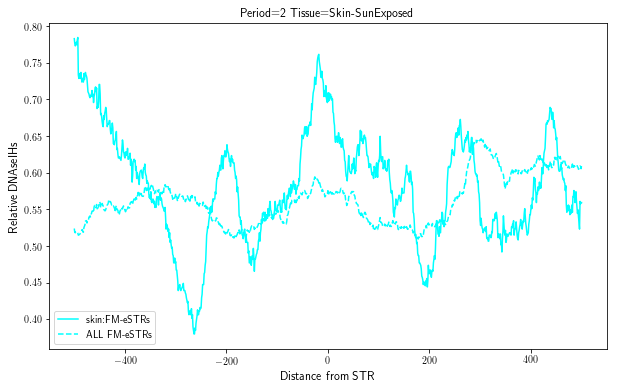

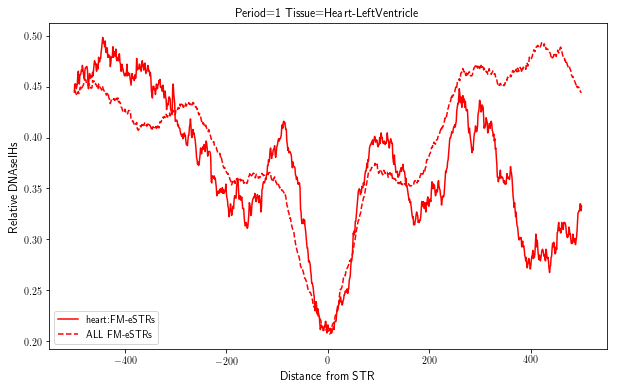

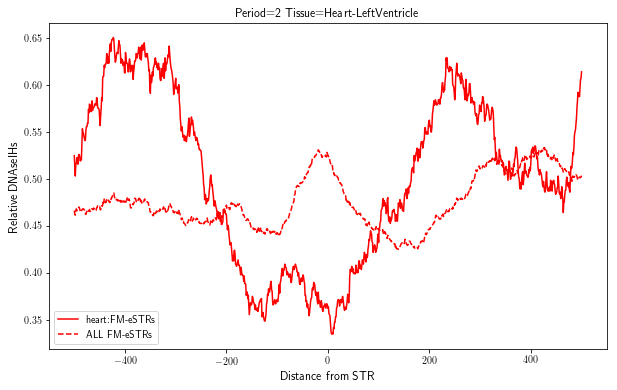

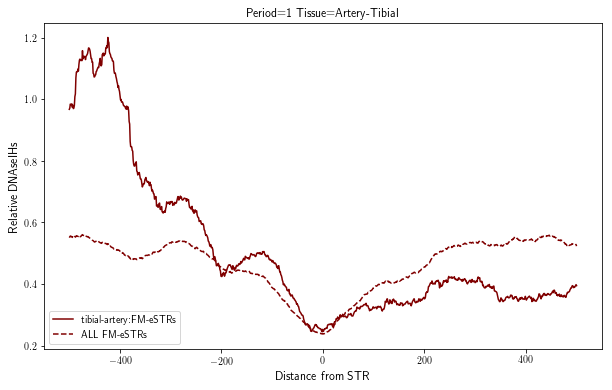

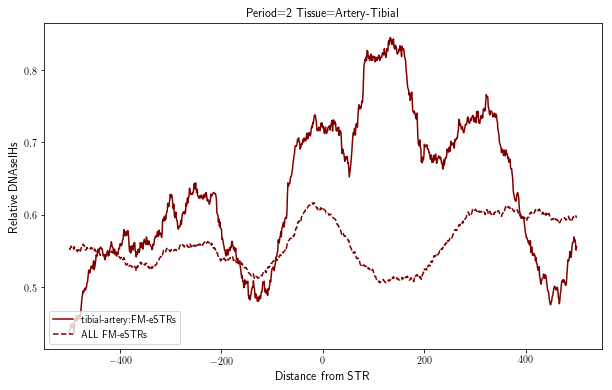

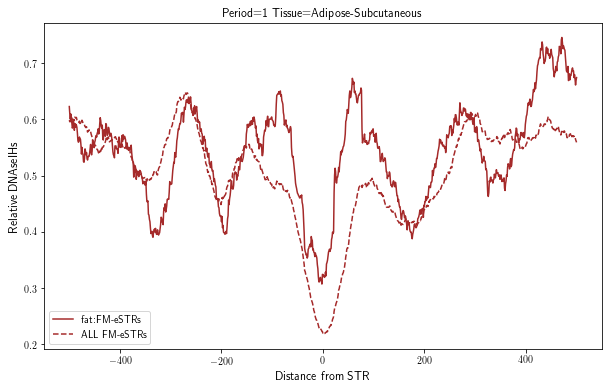

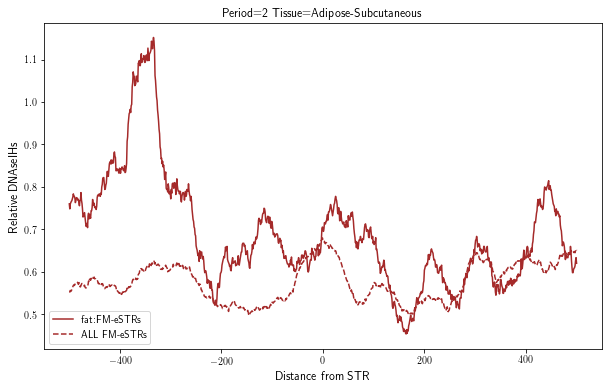

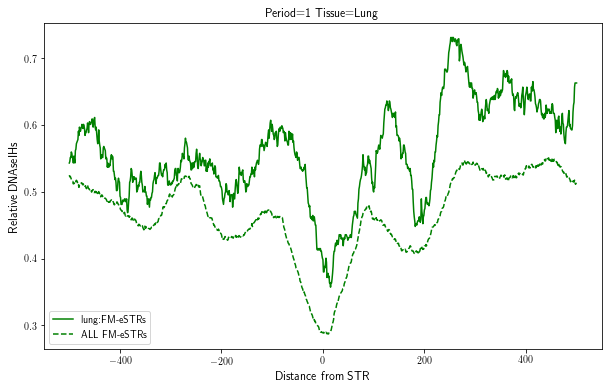

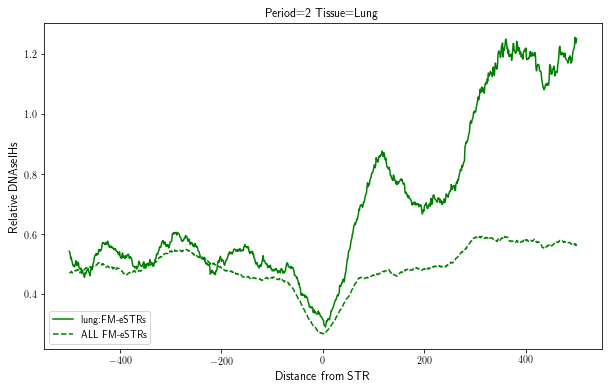

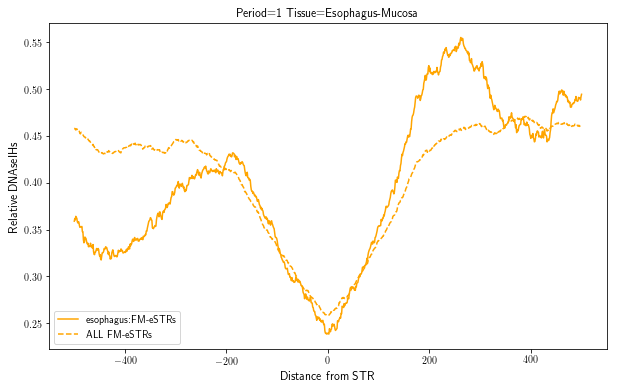

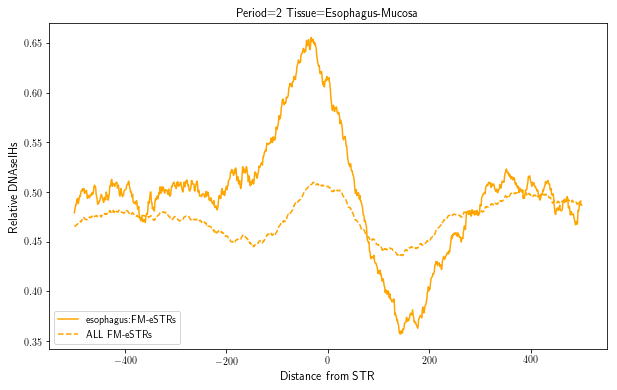

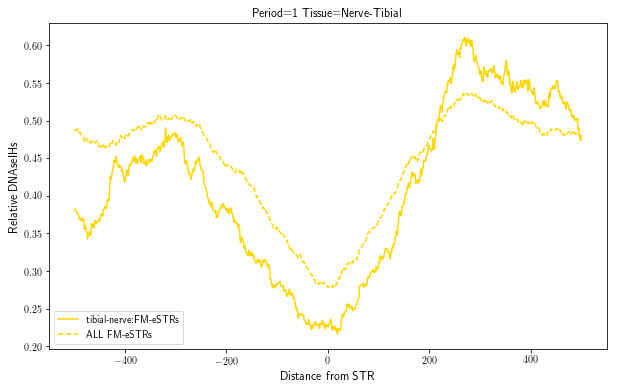

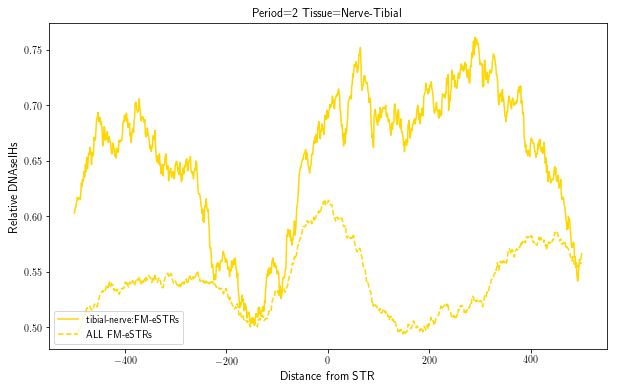

In [8]:
# Plot DNAseI by period - causal vs. all STRs, now restricting causal to certain tissue type

preftissue = {
    "Esophagus-Mucosa": ["esophagus"],
    "Adipose-Subcutaneous": ["fat"],
    "Skin-SunExposed": ["skin"],
    "Heart-LeftVentricle": ["heart"],
    "Lung": ["lung"],
    "Artery-Tibial": ["tibial-artery"],
    "Nerve-Tibial": ["tibial-nerve"]
}

for tissue in preftissue.keys():
    for period in range(1, 3):
        d = dnasedata_by_tissue[tissue][period-1]
        dall = dnasedata[period-1]
        fig = plt.figure()
        fig.set_size_inches((10,6))
        ax = fig.add_subplot(111)
        for pref in preftissue[tissue]: #prefcols:
            if pref == "aheart": continue # this one looks weird
            ax.plot(d["dist"],d["cov.%s"%pref], color=prefcol[pref], label=pref+":FM-eSTRs")
            ax.plot(dall["dist"],dall["cov.%s"%pref], color=prefcol[pref], linestyle="dashed", label="ALL FM-eSTRs")
        ax.set_xlabel("Distance from STR", size=12)
        ax.set_ylabel("Relative DNAseIHs", size=12)
        ax.set_title("Period=%s Tissue=%s"%(period,tissue))
        ax.legend(loc="lower left")